In [1]:
import os

import librosa, librosa.display
import IPython.display as ipd
from random import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm

PROCESSED_DATA_PICKLE_PATH = '../data/df_normal.pkl'

EMOTIONS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

MFCC_LENGTH = 125


In [2]:
def load_data(data_path):
    df = pd.read_pickle(data_path)

    # clean up data
    # vals = []
    # for i, val in enumerate(df["mfcc"].to_numpy()):
    #     if len(val) < MFCC_LENGTH:
    #         vals.append(i)
    #
    # df = df.drop(vals)
    # df = df.reset_index(drop=True)

    X = np.stack(df["mfcc"].to_numpy())
    y = np.stack(df["emotion"].to_numpy())

    return X, y

In [3]:
def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data(PROCESSED_DATA_PICKLE_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # 3d array -> (130, 13, 1)
    X_train = X_train[..., np.newaxis] # 4d array -> (number_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)



data_df = pd.read_pickle(PROCESSED_DATA_PICKLE_PATH)

df_train, df_test = train_test_split(data_df, test_size=0.2, random_state=42, shuffle=True)

X_train = np.stack(df_train['mfcc'].to_numpy())
X_train = X_train[..., np.newaxis]
y_train = np.stack(df_train['emotion'].to_numpy())

X_test = np.stack(df_test['mfcc'].to_numpy())
X_test = X_test[..., np.newaxis]
y_test = np.stack(df_test['emotion'].to_numpy())

In [4]:
def build_model(input_shape):

    # create model
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    # model.add(keras.layers.BatchNormalization())

    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    # model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_model(input_shape)

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(
    X_train,
    y_train,
    # validation_data=(X_validation, y_validation),
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=2
)

# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 1, 32)         4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 1, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [5]:
## calc avg performance
#
# acc_list = []
#
# for i in range(1, 11):
#     input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
#     model = build_model(input_shape)
#
#     # compile network
#     optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#
#     # model.summary()
#
#     history = model.fit(
#         X_train,
#         y_train,
#         # validation_data=(X_validation, y_validation),
#         validation_data=(X_test, y_test),
#         epochs=50,
#         batch_size=16,
#         verbose=0
#     )
#
#     # evaluate the CNN on the test set
#     test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
#     print("Accuracy on test set is: {}".format(test_accuracy))
#
#     acc_list.append(round(test_accuracy, 2))

In [6]:
def predict(model, X, y):

    X = X[np.newaxis, ...]

    # prediction = [ [0.1, 0.2, ...] ]
    prediction = model.predict_classes(X)[0] # X -> (130, 13, 1)

    print("Expected Emotion: {}, Predicted Emotion: {}".format(EMOTIONS[y], EMOTIONS[prediction]))


# make prediction on a sample
X = X_test[69]
y = y_test[69]
predict(model, X, y)

Expected Emotion: sad, Predicted Emotion: fearful


In [2]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

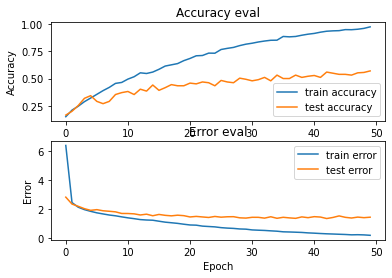

In [8]:
plot_history(history)
